**Food delievery time prediction**

In [1]:
# Phase 1: Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np

In [3]:
# Load Dataset
df = pd.read_csv('/content/Food_Delivery_Time_Prediction.csv')
df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


### Missing Values & Descriptive Stats

In [4]:
# Check missing values
print(df.isnull().sum())

# Summary statistics
df.describe()

Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64


,Distance,Delivery_Person_Experience,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,11.498050,5.250000,3.738500,3.686500,70.494950,1046.488700,46.616650
std,6.841755,2.745027,0.703021,0.697063,29.830694,548.568922,29.361706
min,0.520000,1.000000,2.500000,2.600000,15.230000,122.300000,1.240000
25%,6.090000,3.000000,3.200000,3.100000,46.997500,553.270000,21.602500
50%,10.265000,5.000000,3.800000,3.700000,72.775000,1035.950000,47.530000
75%,16.497500,8.000000,4.300000,4.300000,96.650000,1543.125000,70.245000
max,24.900000,10.000000,5.000000,5.000000,119.670000,1997.420000,99.740000


### Outlier Detection

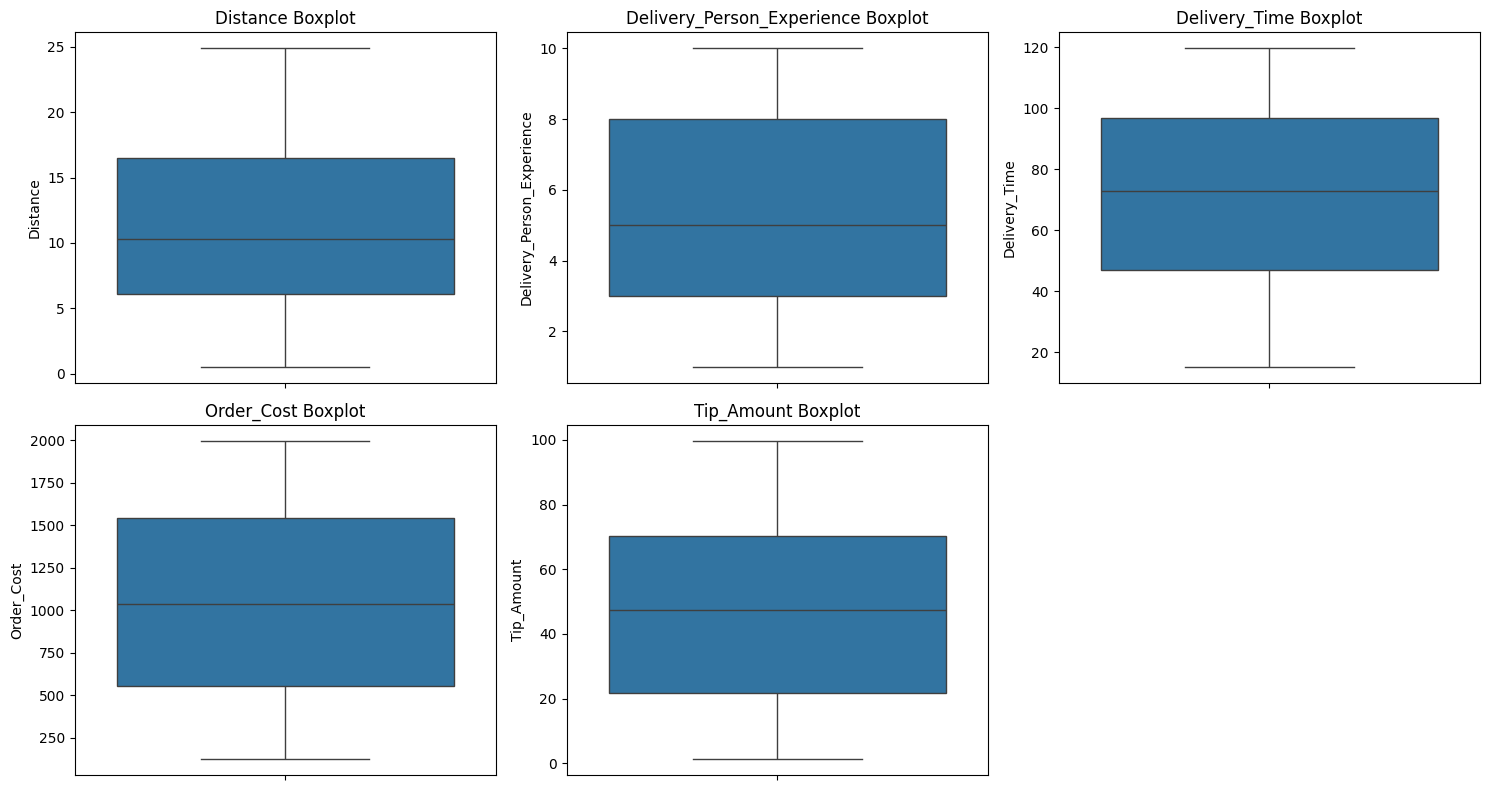

In [5]:
features = ['Distance', 'Delivery_Person_Experience', 'Delivery_Time', 'Order_Cost', 'Tip_Amount']
plt.figure(figsize=(15, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[feature])
    plt.title(f'{feature} Boxplot')
plt.tight_layout()
plt.show()

### Encode Categorical + Normalize Numeric Features

In [8]:
categorical_cols = ['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 'Order_Time', 'Vehicle_Type']
numeric_cols = ['Distance', 'Delivery_Person_Experience', 'Restaurant_Rating', 'Customer_Rating', 'Order_Cost', 'Tip_Amount']

ohe = OneHotEncoder(drop='first', sparse_output=False)
scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('cat', ohe, categorical_cols),
    ('num', scaler, numeric_cols)
], remainder='passthrough')

df_processed = preprocessor.fit_transform(df)

# Get the fitted one-hot encoder from the preprocessor
fitted_ohe = preprocessor.named_transformers_['cat']

feature_names = list(fitted_ohe.get_feature_names_out(categorical_cols)) + numeric_cols + ['Order_ID', 'Customer_Location', 'Restaurant_Location', 'Delivery_Time']
df_final = pd.DataFrame(df_processed, columns=feature_names)
df_final.head()

,Weather_Conditions_Rainy,Weather_Conditions_Snowy,Weather_Conditions_Sunny,Traffic_Conditions_Low,Traffic_Conditions_Medium,Order_Priority_Low,Order_Priority_Medium,Order_Time_Evening,Order_Time_Morning,Order_Time_Night,...,Distance,Delivery_Person_Experience,Restaurant_Rating,Customer_Rating,Order_Cost,Tip_Amount,Order_ID,Customer_Location,Restaurant_Location,Delivery_Time
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,-1.454738,-0.456512,0.5155,-0.987317,0.501852,1.192403,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",26.22
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.439192,1.004325,1.0859,0.738511,-1.634294,-0.60081,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",62.61
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,-0.666417,1.369535,-0.625302,-0.412041,1.092646,0.599332,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",48.43
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.335835,-1.18693,-0.767902,0.019416,-0.923323,1.113532,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",111.63
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-0.700119,0.273907,-0.340101,-1.274955,-0.779755,-1.511757,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",32.38


### 📊 Additional Data Visualizations

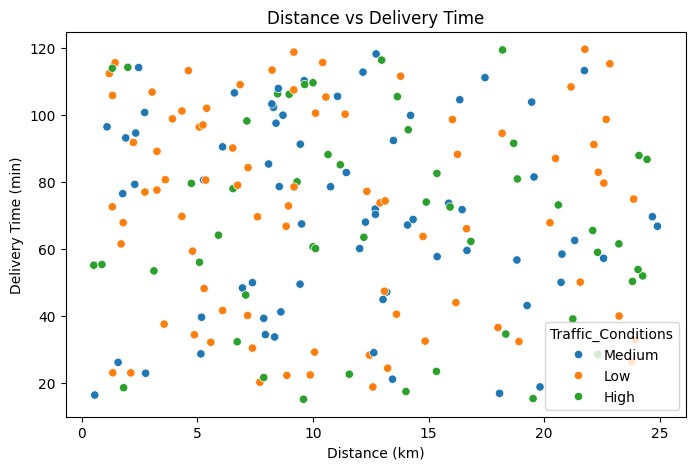

In [9]:
# Scatter Plot: Distance vs Delivery Time
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='Distance', y='Delivery_Time', hue='Traffic_Conditions')
plt.title('Distance vs Delivery Time')
plt.xlabel('Distance (km)')
plt.ylabel('Delivery Time (min)')
plt.show()

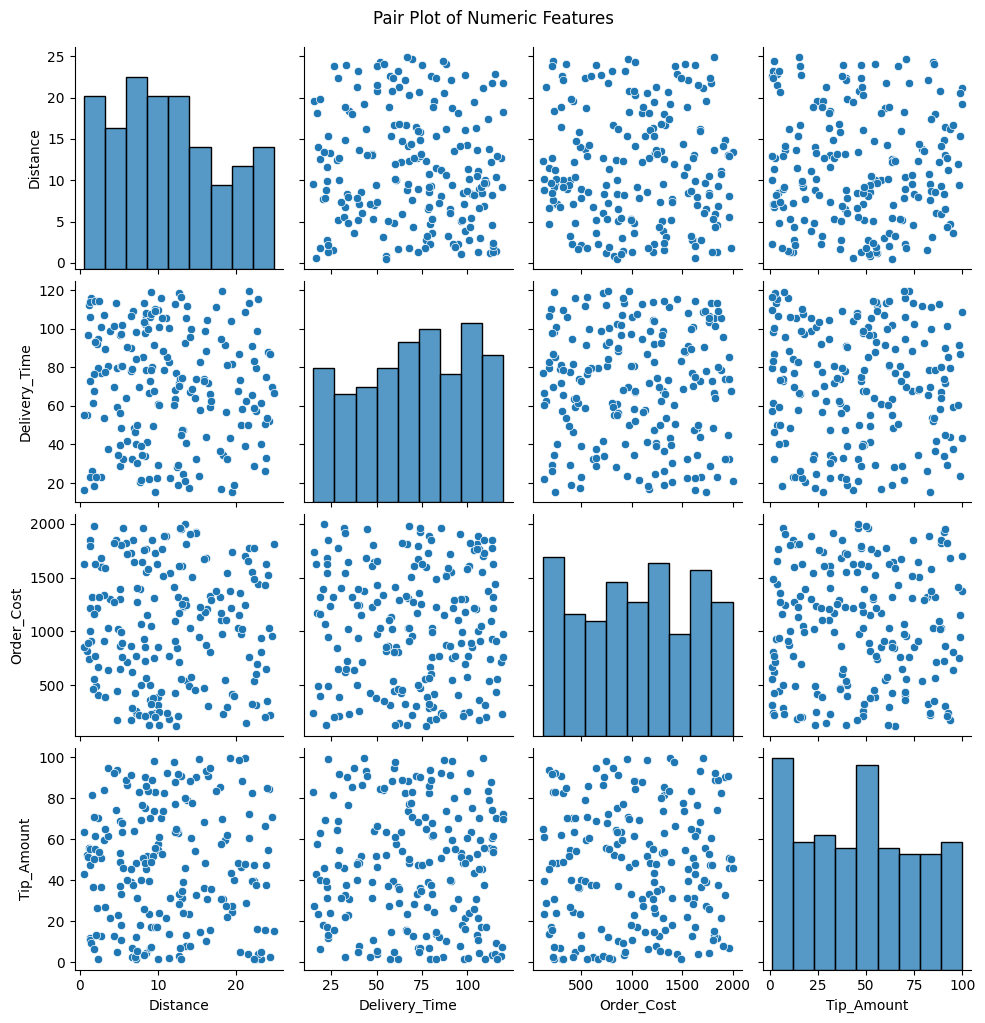

In [10]:
# Pair Plot for numeric variables
sns.pairplot(df[['Distance', 'Delivery_Time', 'Order_Cost', 'Tip_Amount']])
plt.suptitle('Pair Plot of Numeric Features', y=1.02)
plt.show()

# 📈 Phase 2: Predictive Modeling

### Linear Regression to Predict Delivery Time

In [11]:
# Use all features except last 4 + Delivery_Time
X = df_final.iloc[:, :-4]
y = df_final['Delivery_Time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 1021.9359676315067
MAE: 27.184522740542167
R² Score: -0.10492559254944944


### Logistic Regression to Classify Delivery as Fast/Delayed

Accuracy: 0.35
Precision: 0.4166666666666667
Recall: 0.45454545454545453
F1 Score: 0.43478260869565216


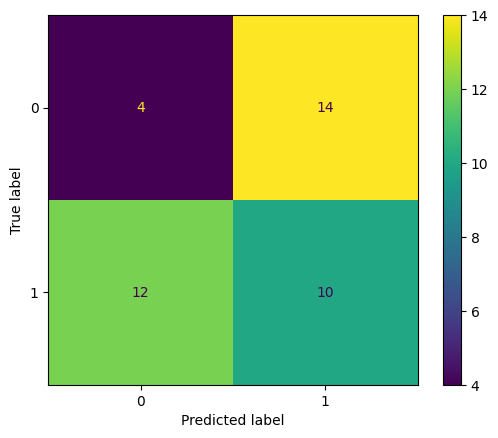

In [12]:
# Define binary class: Fast (<70 min) or Delayed (>=70 min)
df_final['Delivery_Status'] = df_final['Delivery_Time'].apply(lambda x: 1 if x >= 70 else 0)

X = df_final.iloc[:, :-5]
y = df_final['Delivery_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix).plot()

# 📊 Phase 3: Insights & Recommendations

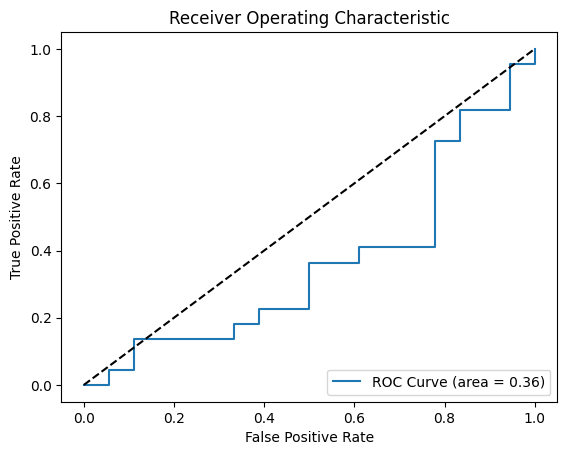

In [13]:
# ROC Curve for Logistic Regression
y_prob = log_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Actionable Insights
- **Route Optimization:** Deliveries take longer with greater distances and high traffic.
- **Rush Hour Identification:** Order Time and Traffic Conditions have strong impact.
- **Experience Matters:** More experienced delivery staff correlate with faster deliveries.
- **Vehicle Type Impact:** Bikes may be more effective in high-traffic areas.
- **Staffing Strategy:** Schedule more experienced staff during peak hours.

#  Final Report Summary##  Dataset Description
- 200 food delivery orders.
- Features include location coordinates, weather, traffic, ratings, vehicle type, delivery person experience, cost, and tips.
- Target variable: `Delivery Time` (continuous).

##  Preprocessing Steps
- Handled missing values (none found).
- One-hot encoded categorical features.
- Normalized numerical features.
- Outliers analyzed using boxplots.

##  Model Evaluation
**Linear Regression:**
- Predicts delivery time using all features.
- Evaluated with MSE, MAE, R².

**Logistic Regression:**
- Classifies deliveries as Fast (<70min) or Delayed.
- Evaluated with Accuracy, Precision, Recall, F1-score, Confusion Matrix, and ROC Curve.

## Actionable Recommendations
- Optimize delivery routes by analyzing peak traffic and distance.
- Schedule experienced delivery personnel during peak hours.
- Improve delivery times in high-traffic areas by using appropriate vehicle types.
- Monitor orders with low restaurant/customer ratings for potential delays.
- Use predictive models for proactive staffing and delivery management.
